# Simulation of MLP by using pivots and visual analytics

## Part 1

In [1]:
pip install mnists

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from mnists import FMNIST

RANDOM_STATE = 42
NUM_CLASSES = 10
SAMPLE_SIZE = 10000  # Use only a subset of the data to speed up the process

K_values = [5, 10, 15, 20]  # Different values of K for pivot samples

# Class names for the Fashion MNIST dataset
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

### Load and Preprocess Data

#### Load the Fashion MNIST dataset

In [3]:
def load_fmnist():
    mnist = FMNIST()
    x_train = mnist.train_images()
    y_train = mnist.train_labels()
    x_test = mnist.test_images()
    y_test = mnist.test_labels()
    return (x_train, y_train), (x_test, y_test)


(x_train, y_train), (x_test, y_test) = load_fmnist()
X = np.concatenate([x_train, x_test], axis=0).reshape(-1, 28 * 28)[:SAMPLE_SIZE]
y = np.concatenate([y_train, y_test], axis=0)[:SAMPLE_SIZE]

In [4]:
X.shape, y.shape

((10000, 784), (10000,))

#### Normalize Feature Vectors

In [5]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

### Select Random Pivoting Samples

In [6]:
def select_pivot_samples(X, y, num_classes, k):
    pivot_samples = []
    for cls in range(num_classes):
        cls_indices = np.where(y == cls)[0]
        selected_indices = random.sample(list(cls_indices), k)
        pivot_samples.extend(X[selected_indices])
    return np.array(pivot_samples)


pivot_samples = {
    k: select_pivot_samples(X_normalized, y, NUM_CLASSES, k) for k in K_values
}

### Calculate representations

#### Define Activation Functions

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)


activation_functions = {
    "Sigmoid": sigmoid,
    "ReLU": relu,
    "Softmax": softmax,
}

#### Calculate tSNE and transformed data tSNE representations

In [8]:
def calculate_representation(X, pivots, activation_function):
    X1 = np.dot(X, pivots.T)
    return activation_function(X1)

# Calculate tSNE representations for the original data and for different representations
tsne_results = {}
tsne_original = TSNE(n_components=2, random_state=RANDOM_STATE).fit_transform(
    X_normalized
)
tsne_results["Original"] = tsne_original

for k in K_values:
    for name, func in activation_functions.items():
        X_transformed = calculate_representation(X_normalized, pivot_samples[k], func)
        tsne_results[f"{name}_k={k}"] = TSNE(
            n_components=2, random_state=RANDOM_STATE
        ).fit_transform(X_transformed)

/tmp/ipykernel_61544/1708810439.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_61544/1708810439.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_61544/1708810439.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/tmp/ipykernel_61544/1708810439.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


### tSNE Projections Visualization

#### Helper functions

In [9]:
def plot_tsne(tsne_result, y, ax, title):
    for cls in range(NUM_CLASSES):
        cls_indices = np.where(y == cls)[0]
        ax.scatter(
            tsne_result[cls_indices, 0],
            tsne_result[cls_indices, 1],
            label=class_names[cls],
            alpha=0.5,
        )
    ax.legend()
    ax.set_title(title)


def visualize_original(tsne_result, y):
    plt.figure(figsize=(8, 6))
    for cls in range(NUM_CLASSES):
        cls_indices = np.where(y == cls)[0]
        plt.scatter(
            tsne_result[cls_indices, 0],
            tsne_result[cls_indices, 1],
            label=class_names[cls],
            alpha=0.5,
        )
    plt.legend()
    plt.title("tSNE Visualization of Original Data Set")
    plt.show()


def visualize_tsne_results(tsne_results, y):
    fig, axes = plt.subplots(len(K_values), len(activation_functions), figsize=(15, 20))

    for i, k in enumerate(K_values):
        for j, (name, _) in enumerate(activation_functions.items()):
            ax = axes[i, j]
            tsne_result = tsne_results[f"{name}_k={k}"]
            plot_tsne(tsne_result, y, ax, f"{name} Activation, k={k}")
            if i == 0:
                ax.set_title(name)
            if j == 0:
                ax.set_ylabel(f"k={k}")

    # Set common labels
    fig.text(0.5, 0.04, "Activation Functions", ha="center", fontsize=12)
    fig.text(
        0.04,
        0.5,
        "Number of Pivot Samples (k)",
        va="center",
        rotation="vertical",
        fontsize=12,
    )
    plt.tight_layout(rect=[0.05, 0.05, 1, 1])
    plt.show()

#### Original dataset visualization

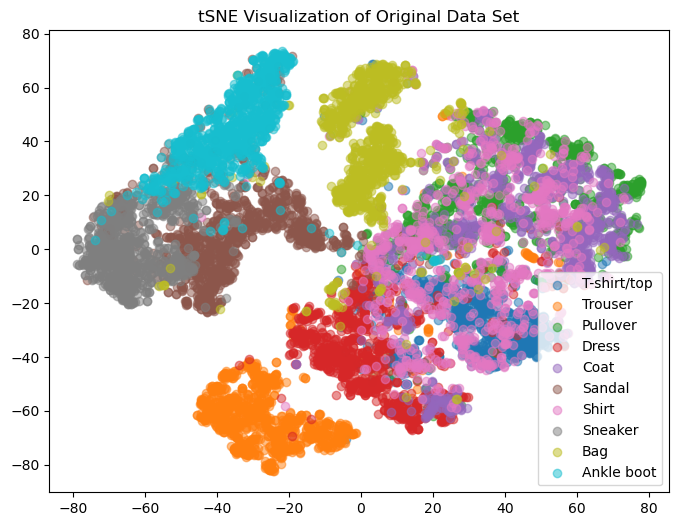

In [10]:
visualize_original(tsne_results["Original"], y)

#### Visualization of $X1$, $X2$, $X3$, $X4$ for different activation functions

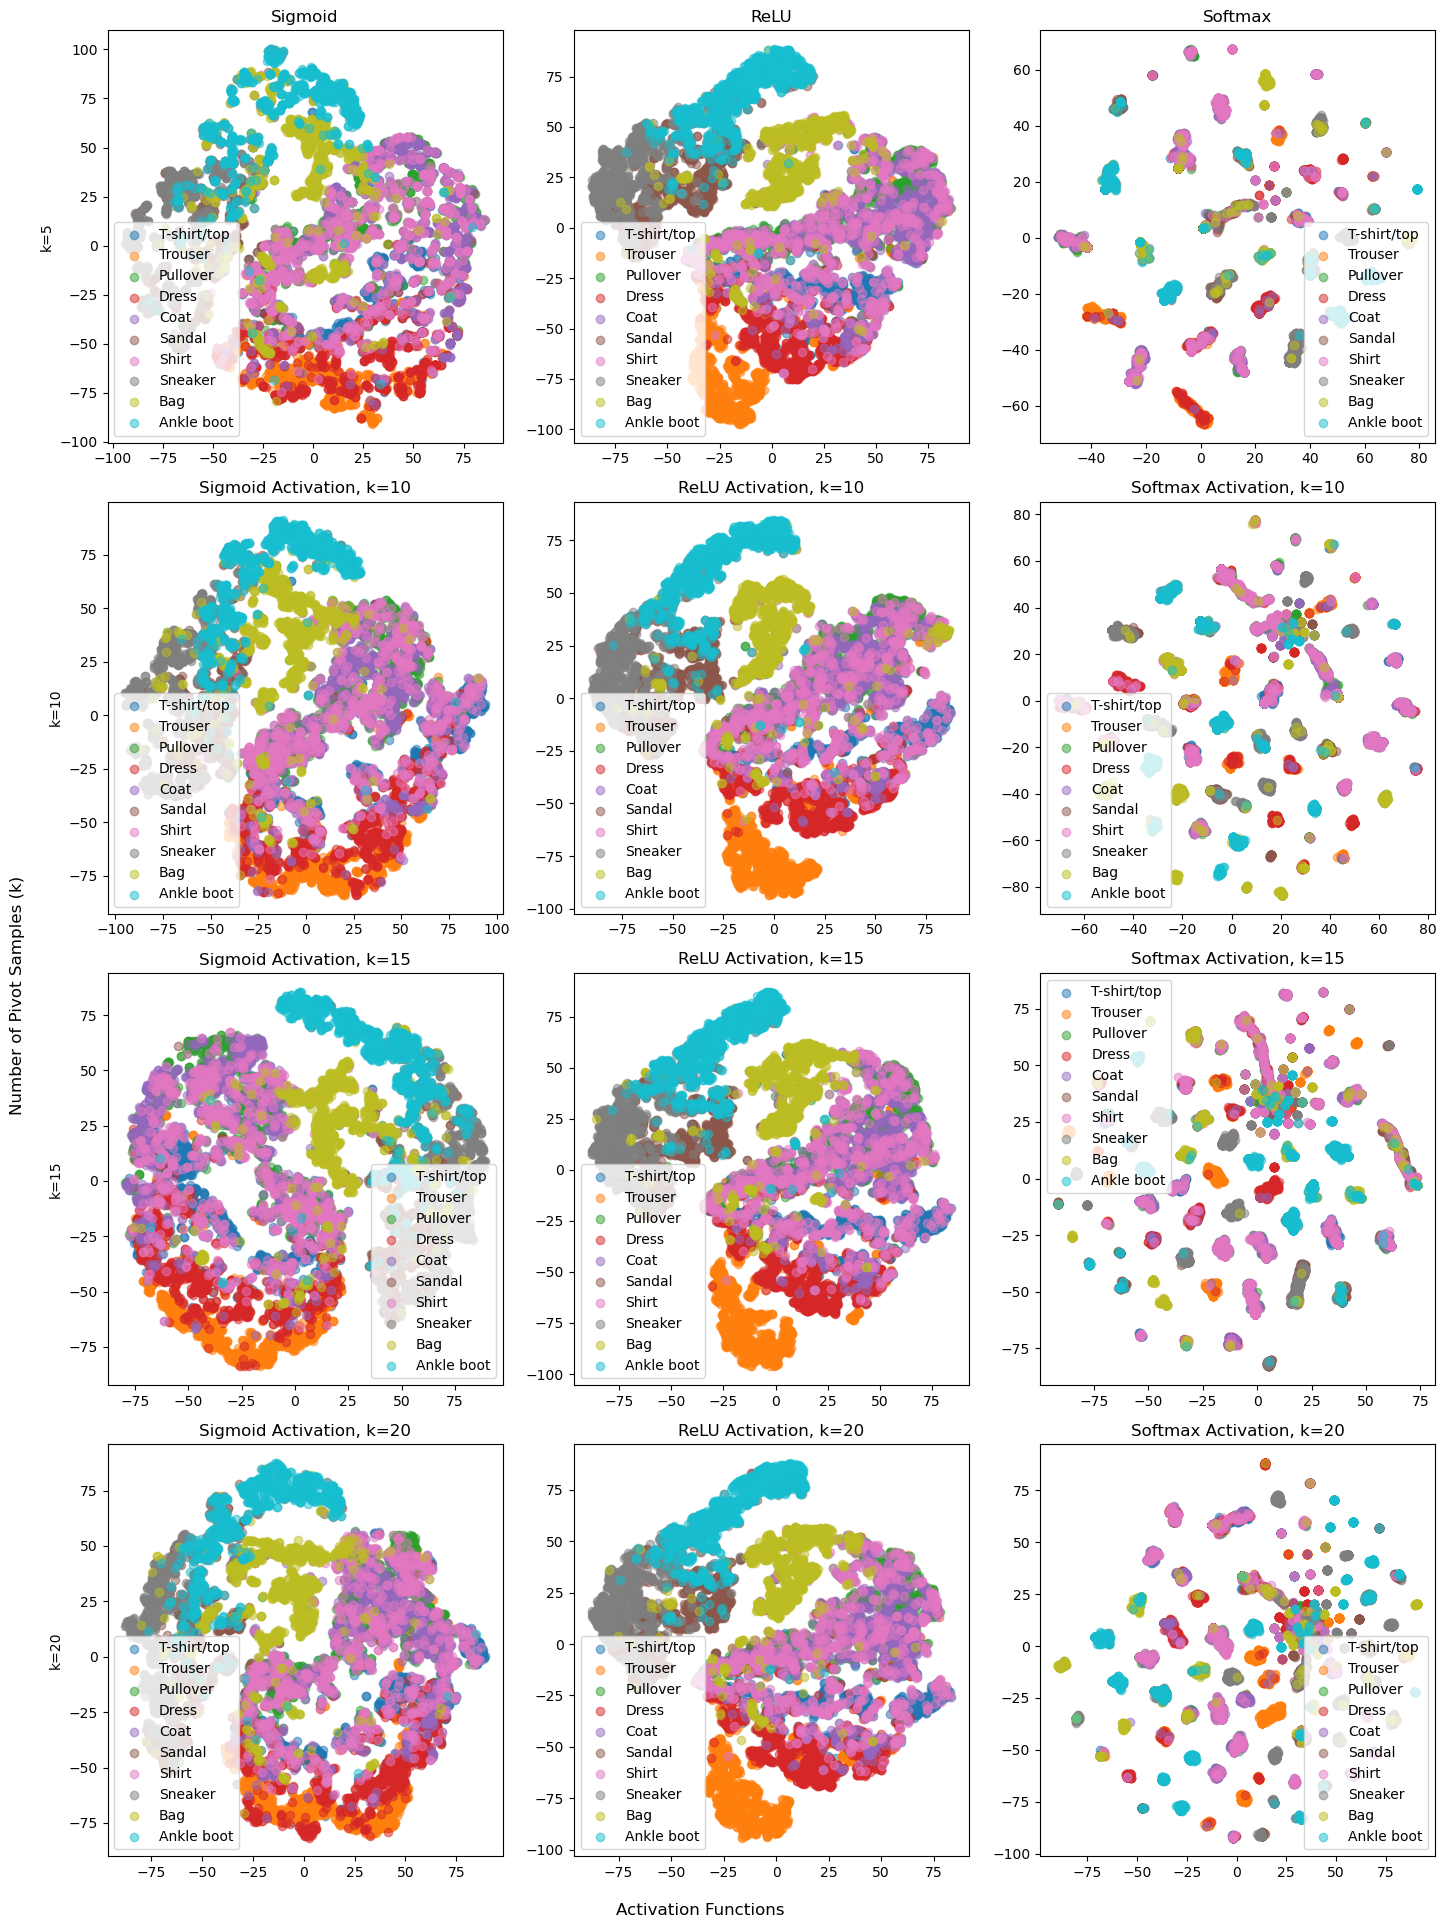

In [11]:
visualize_tsne_results(tsne_results, y)

#### Observations

1. **Sigmoid Activation**:
    - **k=5, k=10, k=15, k=20**: While there is some improvement in cluster separation as k increases, the clusters still exhibit significant overlap, especially at higher k-values. No clear, distinct separation is observed.

2. **ReLU Activation**:
    - **k=5, k=10, k=15, k=20**: Similar to sigmoid, clusters become slightly more defined with increasing k, but substantial overlap remains across all k-values. Some classes like "Trouser" and "Ankle boot" are more distinguishable, but overall separation is not clear.

3. **Softmax Activation**:
    - **k=5, k=10, k=15, k=20**: Clusters are the most scattered and less defined compared to sigmoid and ReLU. Increasing k improves structure slightly, but classes are still highly overlapping and less distinguishable.

##### General Observations:

- **Increasing k (number of pivot samples) generally improves cluster definition but does not achieve clear separation for any activation function.**
- **Sigmoid and ReLU show slight improvements with higher k-values but still suffer from significant overlap.**
- **Softmax consistently shows scattered clusters with the least definition and separation across all k-values.**

## Part 2

### Add Bias Term and Pre-clustering to Select Better Pivots

In [12]:
# Add a bias term (1) to the feature space
X_with_bias = np.hstack([X_normalized, np.ones((X_normalized.shape[0], 1))])


# Pre-clustering to Select Better Pivots using KMeans
def select_pivot_samples_kmeans(X, y, num_classes, k):
    pivot_samples = []
    for cls in range(num_classes):
        cls_indices = np.where(y == cls)[0]
        X_cls = X[cls_indices]

        # Use k-means clustering to find cluster centroids as pivots
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10).fit(X_cls)
        pivot_samples.extend(kmeans.cluster_centers_)
    return np.array(pivot_samples)


pivot_samples_kmeans = {
    k: select_pivot_samples_kmeans(X_with_bias, y, NUM_CLASSES, k) for k in K_values
}

### Define Function to Calculate Representation with Threshold

In [13]:
def calculate_representation_with_threshold(X, pivots, activation_function, threshold):
    distances = cdist(X, pivots)
    X1 = np.where(distances <= threshold, np.dot(X, pivots.T), 0)
    return activation_function(X1)

### Calculate tSNE Representations with Threshold

In [14]:
# Define the threshold for similarity (e.g., the radius of the sphere around a pivot)
similarity_threshold = 7.5

# Calculate tSNE representations for the original data and for different representations with thresholds
tsne_results_threshold = {}

for k in K_values:
    for name, func in activation_functions.items():
        X_transformed = calculate_representation_with_threshold(
            X_with_bias, pivot_samples_kmeans[k], func, similarity_threshold
        )
        tsne_results_threshold[f"{name}_k={k}_threshold={similarity_threshold}"] = TSNE(
            n_components=2, random_state=RANDOM_STATE
        ).fit_transform(X_transformed)

### VIsualization

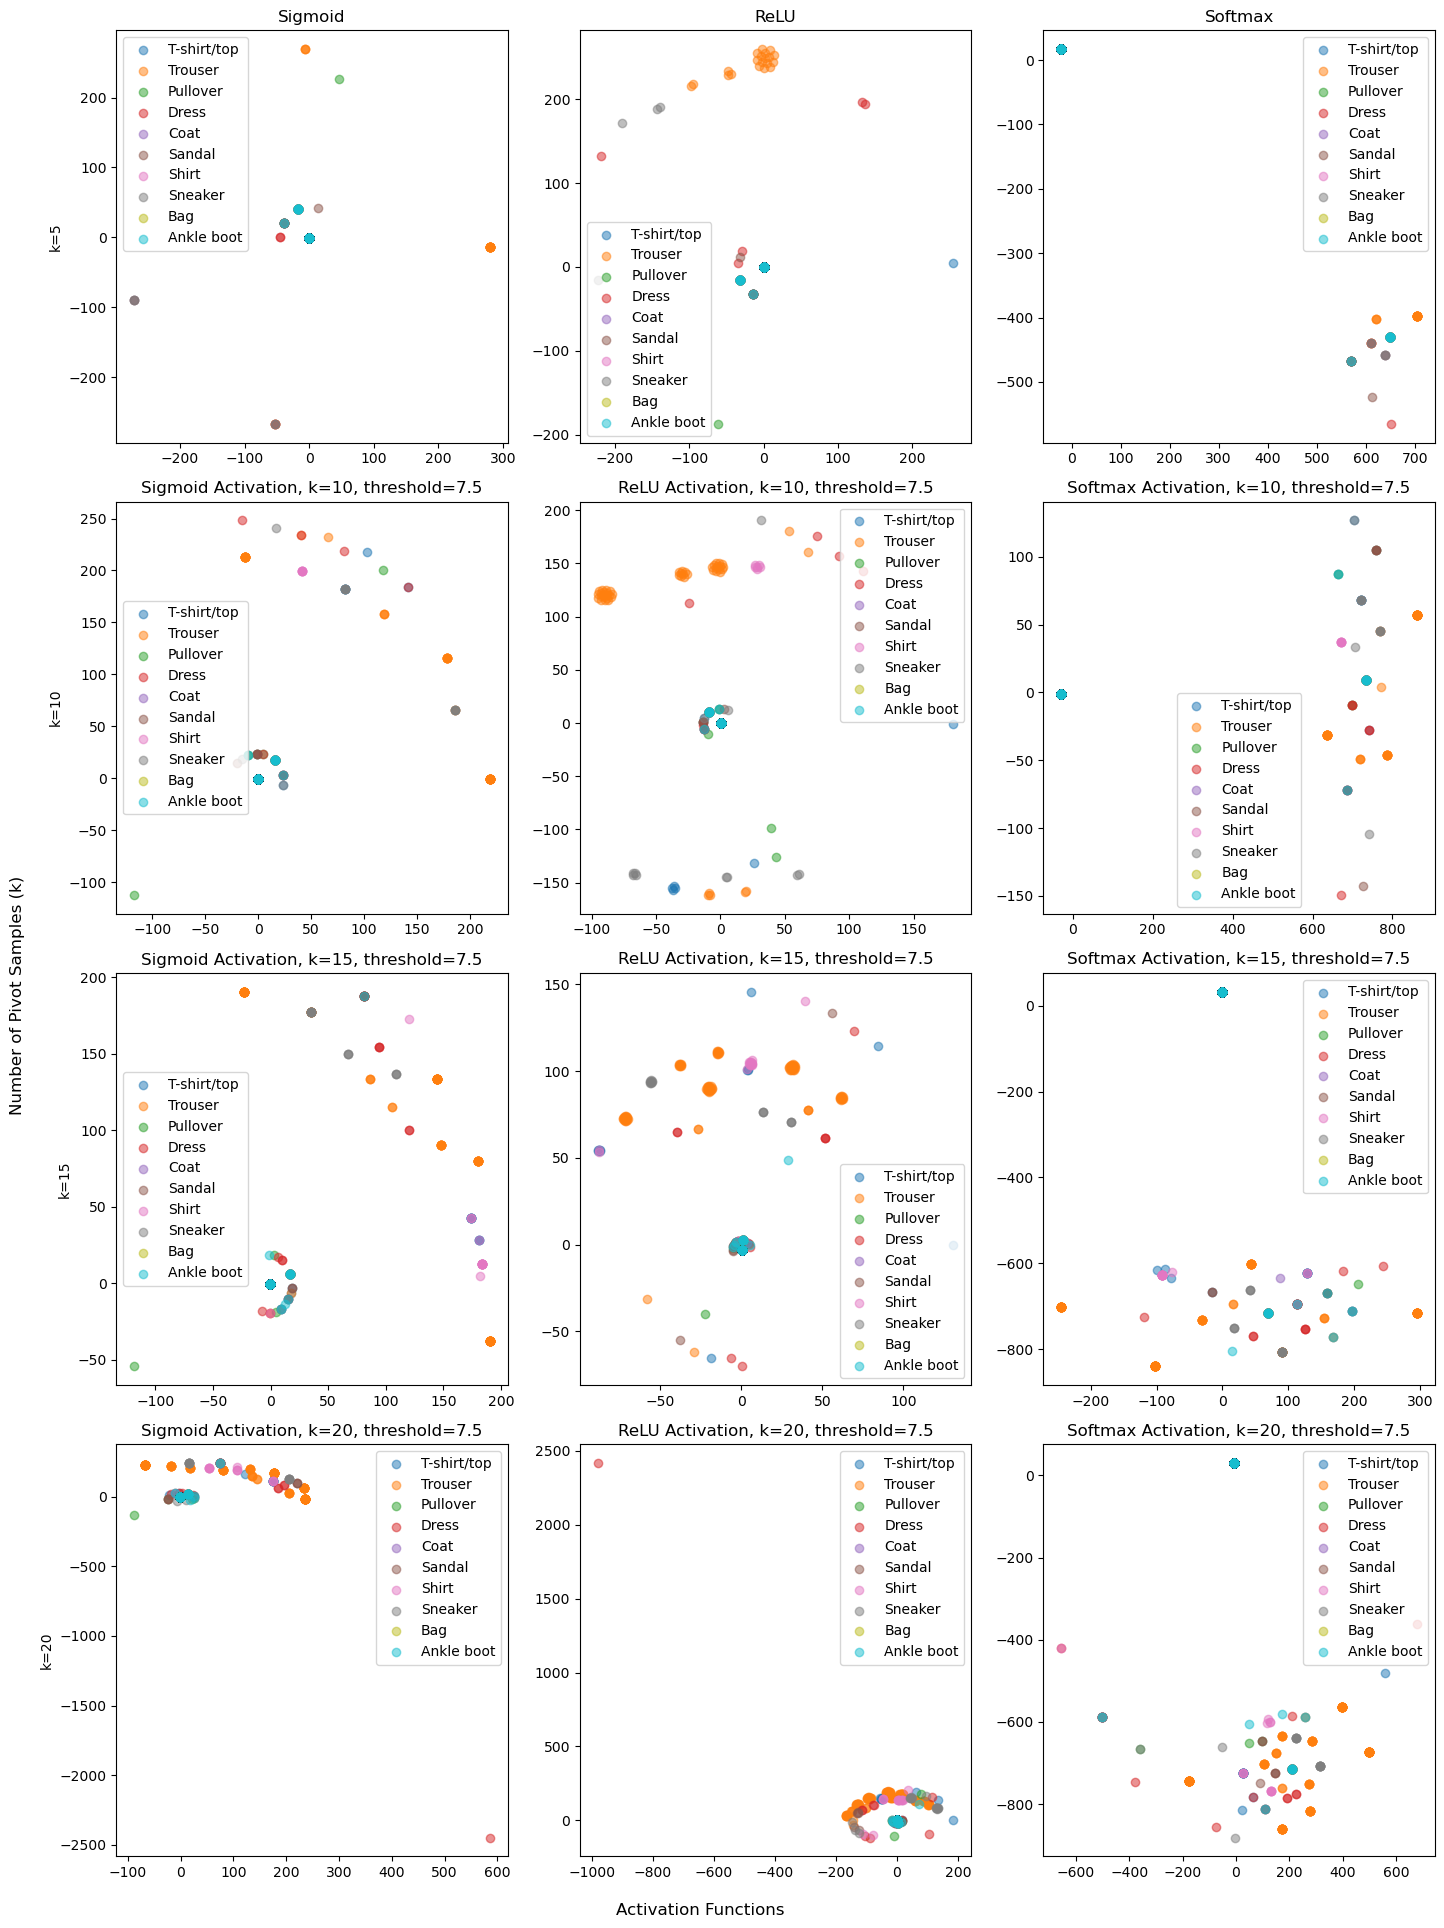

In [15]:
def visualize_tsne_results_threshold(tsne_results, y):
    fig, axes = plt.subplots(len(K_values), len(activation_functions), figsize=(15, 20))

    for i, k in enumerate(K_values):
        for j, (name, _) in enumerate(activation_functions.items()):
            ax = axes[i, j]
            tsne_result = tsne_results[f"{name}_k={k}_threshold={similarity_threshold}"]
            plot_tsne(
                tsne_result,
                y,
                ax,
                f"{name} Activation, k={k}, threshold={similarity_threshold}",
            )
            if i == 0:
                ax.set_title(name)
            if j == 0:
                ax.set_ylabel(f"k={k}")

    # Set common labels
    fig.text(0.5, 0.04, "Activation Functions", ha="center", fontsize=12)
    fig.text(
        0.04,
        0.5,
        "Number of Pivot Samples (k)",
        va="center",
        rotation="vertical",
        fontsize=12,
    )
    plt.tight_layout(rect=[0.05, 0.05, 1, 1])
    plt.show()


# Visualize the results with threshold
visualize_tsne_results_threshold(tsne_results_threshold, y)

#### Observations

1. **Sigmoid Activation**:
    - **k=5, k=10, k=15, k=20 with threshold=7.5**: The clusters are more defined compared to the initial plots without a threshold. There is a slight improvement in the separation of some classes, but significant overlap still remains. The threshold value seems to help in creating tighter clusters but does not achieve clear separability.

2. **ReLU Activation**:
    - **k=5, k=10, k=15, k=20 with threshold=7.5**: Clusters show better definition and less overlap compared to the initial plots. Some classes such as "Trouser" and "Ankle boot" are more distinguishable. The reduction in the threshold value appears to improve the tightness and separation of the clusters.

3. **Softmax Activation**:
    - **k=5, k=10, k=15, k=20 with threshold=7.5**: Clusters remain scattered, similar to the initial observations. The change in threshold does not significantly impact the separability of the clusters, indicating that Softmax may not be well-suited for this task.

## Summary

### Plots comparison (part 1 vs part 2)

#### Previous Plots (Without Threshold):
- **Sigmoid and ReLU**:
    - Showed some improvements in cluster definition as \(k\) increased, but substantial overlap remained.
- **Softmax**:
    - Clusters were the most scattered and least defined.

#### New Plots (With Threshold):
- **Sigmoid**:
    - Slightly better cluster definition compared to the initial plots without a threshold, but still significant overlap and unclear separability.
- **ReLU**:
    - Improved cluster tightness and less overlap compared to the initial plots. Lowering the threshold helps improve the tightness and separation of the clusters.
- **Softmax**:
    - Clusters remain scattered with minimal improvement, suggesting that Softmax is less effective for achieving clear separability.

### Conclusions

- **Threshold Impact**:
    - Introducing a threshold of 7.5 improves cluster tightness and reduces overlap for Sigmoid and ReLU activations compared to the initial plots without a threshold. However, clear class separability is still not achieved.
- **Activation Functions**:
    - **Sigmoid and ReLU** show noticeable improvements with the threshold, but there is still a need for further refinement to achieve better separability.
    - **Softmax** consistently shows poor performance in achieving clear separability, indicating it might not be the best choice for this task.